In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../../NIPMAP(Requierd_Packages)/')) 
if module_path not in sys.path:
    sys.path.append(module_path)
os.getcwd()

'/Users/razi.m/Bs_Molecular_Bioinformatics/Year3/Spring_Semester_2023/Thesis/NIPMAP_on_HIFI_data/HIFI_analysis/notebooks'

### Import requierments packages, NIPMAP packages can be found in src folder.

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from src.CellAbundance import CellAbundance, join_abundance_matrices, generate_abundance_matrix#,get_site_cell_map_dataframe
from src.utils.archetypes import ArchetypalAnalysis
from src.utils.equations import compute_cells_niches_weights,get_niches_cell_abund
from src.utils.visualization import plot_cells_positions,radius_pc_all_variance
from sklearn.decomposition import PCA


### Define the data path and requirements parameter. 

In [3]:
CELLTYPES = ['Astrocyte', 'Fibroblast', 'Neuron', 'Neutrophil', 'T-cell', 'TAM', 'Tumor_A','Vessel','Undefined']

ImageIDs =  ["31801_32Un"] 
Imageinfo = "31801_32Un"
RADIUS = 25 
METHOD ="gaussian"
# the x and y value can be find in r script(maximum of x and y in the rectangle of the image ) 
XSIZE= 3300 
YSIZE = 2800
#calculate the number of sampling sites needed to cover the whole surface of the image 
nsite = int((XSIZE*YSIZE)/((RADIUS**2)*np.pi)) 
print(nsite)
Data_Path = "../data"   
Output_path= "../output"
Fig_path = "../output/fig"             


4705


### Radius analysis 
#### For 10 different radius values, the Gaussian kernel density estimator was used to create cell abundance matrixes by assigning weights to cells per sampling site according to their distance from the randomly selected centers

5.0
7.0
11.0
17.0
25.0
38.0
57.0
85.0
127.0
190.0


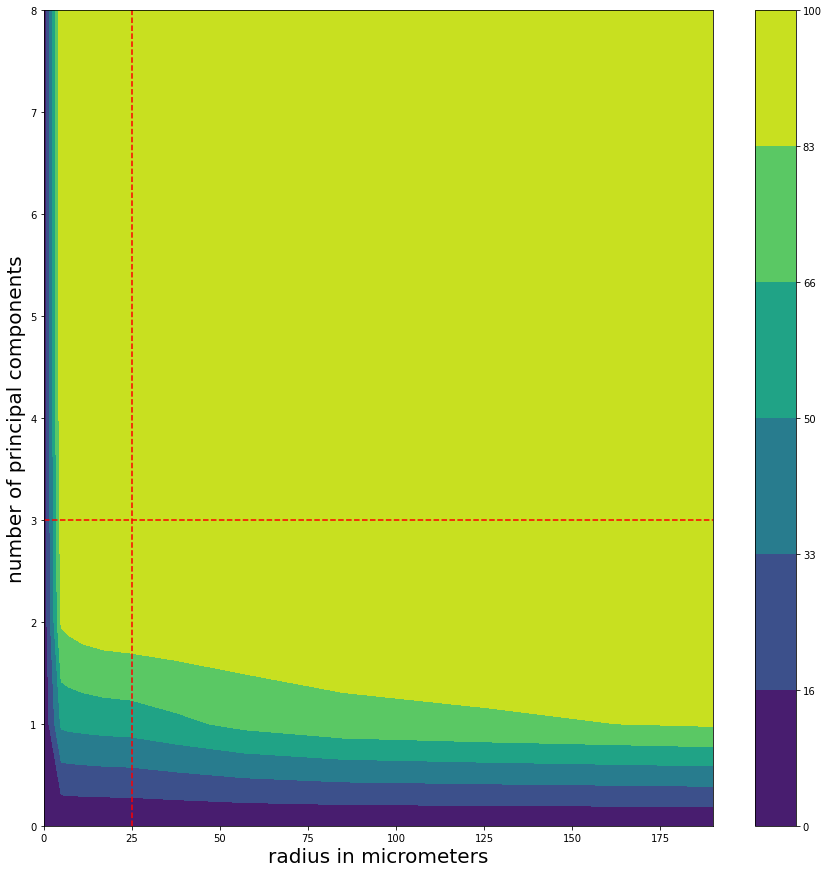

In [4]:
Ra = np.linspace(np.log(5), np.log(190), num=10)# get interval of radiuses
radius = np.rint(np.power(np.e,Ra).astype(float))
 
NSITES = 4700  # number of sites
ExVaRaGa ={} 
# Get explained variace of each PC on sites cell abundance interating on radius size of sites
for r in radius:
    print(r)
    count_list_gussian = generate_abundance_matrix(CELLTYPES, ImageIDs, NSITES, r,
                       center_sites_cells=False,method=METHOD,image_x_size=XSIZE,
                       image_y_size=YSIZE, snr=3, root=Data_Path)
    
    sites, patient_ids,s_ids, _ = join_abundance_matrices(count_list_gussian)
    pca = PCA()
    pc = pca.fit_transform(sites) # pca on sites
    ExVaRaGa[r] = np.cumsum(pca.explained_variance_ratio_)
ExVaRaGa[r]    

radius_pc_all_variance(ExVaRaGa,radius_lim=25,nPC_lim=3,save_fig=True,
                      cells_number=len(CELLTYPES)+1,
                      path_fig = Fig_path+"/plot_rad_var_gauss_%s.svg" %(Imageinfo))


### Generate sampling sites and cell aboundance 

In [6]:

RADIUS = int(input('Enter Radius for sampling sites(in micrometers/should be int):\n'))  
    
CeAbLi = generate_abundance_matrix(CELLTYPES, ImageIDs, NSITES,RADIUS,method=METHOD,
                                  random_seed=1022,snr=3,center_sites_cells=False,
                                   root=Data_Path)

sites, patients_ids,sites_ids, _ = join_abundance_matrices(CeAbLi)


print("Generating sites with cell abundance...")

#create a data frame from the output of the abundance matrix

CeAbDf = pd.DataFrame()
for i in CeAbLi:
    df_Ab = pd.DataFrame(i.abundance_matrix,columns = CELLTYPES)
    df_Ab['site_id'] = np.arange(len(df_Ab))
    df_Ab['patient_id'] = i.patient_id
    CeAbDf = CeAbDf.append(df_Ab)

CeAbDf = CeAbDf.reset_index()
CeAbDf

#create a dictionary of cell abundance of randomly generated sites
CeAbSiDi = {"cellAbSites": CeAbDf.to_dict()}

# Serializing json objects
CeAbSi_json = json.dumps(CeAbSiDi,indent=4) # cell abundance of randomly generated sites

print("save cell abundance of randomly generated sites as a json file... ")

# Writing to .json files to be later use in r 
with open(Output_path+ "/CeAbSi_%s.json" %(Imageinfo),"w") as f1:
    f1.write(CeAbSi_json)


Enter Radius for sampling sites(in micrometers/should be int):
25
Generating sites with cell abundance...
save cell abundance of randomly generated sites as a json file... 


### PCA on sites abundance 

In [7]:
print("Dimension reduction of sites cell abundances...")
PcOb = PCA()
PcSi = PcOb.fit_transform(sites)
PcSi 

#create a dictionary of PCA summary
PcDi = {"PcSi":PcSi.tolist(),
        "components":PcOb.components_.tolist(),
        "expl_variance":PcOb.explained_variance_.tolist(),
        "expl_var_ratio":PcOb.explained_variance_ratio_.tolist(),
        "mean":PcOb.mean_.tolist()}


print("save PCA analysis as a json file... ")

# Serializing json objects
PCA_json = json.dumps(PcDi, indent=4) # PCA

# Writing to .json files to be later use in r 

with open(Output_path+"/pca_sites_%s.json" %(Imageinfo), "w") as f2:
    f2.write(PCA_json)

Dimension reduction of sites cell abundances...
save PCA analysis as a json file... 


### Find the optimal number of archetype
#### Archetype analysis was done for a range of 3 to 9 archetypes. 

In [ ]:
 
NoAr = list(range(3, 10))
ExVa = []
for i in NoAr:
    ArAa = ArchetypalAnalysis(n_archetypes = i, 
                        tolerance = 0.001, 
                        max_iter = 200, 
                        random_state = 0, 
                        C = 0.0001, 
                        initialize = 'random',
                        redundancy_try = 30)
    ArAa.fit(PcSi[:, :3])
    ExVa.append( ArAa.explained_variance_)

plt.plot(NoAr , ExVa, '-o')
plt.xlabel('Number of Archytypes')
plt.ylabel('explained variance')
plt.savefig("../output/fig/optimal_number_of_archytype_%s.png" %(Imageinfo))
plt.ylim(0, 1)
plt.show()


### To use the same colors for visualization in R, define the color based on the number of niches, convert RGB color to hex color, and save the file as a json.

In [8]:
 
#COLARCHS =[(255,0,223),(70,203,236),(247,221,25),(8, 94, 4)] # 4 niches
#COLARCHS = [(255,0,223),(13, 189, 60),(70,203,236),(240, 158, 17),(0,0,0)] # 5 niches
#COLARCHS = [(255,0,223),(13, 189, 60),(70,203,236),(240, 158, 17),(240, 17, 35),(0,0,0)] # 6 niches
COLARCHS = [(255,0,223),(70,203,236),(240, 17, 35),(240, 158, 17),(13, 189, 60),(108, 115, 196),(0,0,0)] # 7 niches
#COLARCHS = [(255,0,223),(70,203,236),(240, 17, 35),(240, 158, 17),(13, 189, 60),(108, 115, 196),(192, 214, 21),(0,0,0)] # 8 niches

NiCo = [] # empty list

# get each item of color list and convert it to hex color
def RGB_HEX(ColorList):
    for i in ColorList: 
        x= '#%02x%02x%02x' % i
        NiCo.append(x)
    return (NiCo)

RGB_HEX(COLARCHS)

print("save hex colors as a json file... ")

NiCo ={"Niche_color": NiCo} # create a dictionary of the hex color 

# Serializing json objects
NiCo_json = json.dumps(NiCo,indent=4 )# Niches color code 

# Writing to .json files to be later use in r 
with open(Output_path+ "/niches_color_%s.json" %(Imageinfo),"w") as f3:
    f3.write(NiCo_json)

    


save hex colors as a json file... 


### Archetype analysis
#### Archetype analysis was done based on the chosen archetype and by using the "get_niches_cell_abund" function to generate niche cell abundance. To plot the cell abundance in each niche, a data frame of the output was created.

In [9]:
print("Finding niches...")
NoNi = 7
ncomp= NoNi-1
ArAn = ArchetypalAnalysis(n_archetypes =NoNi,
                 tolerance = 0.001,
                 max_iter = 200,
                 random_state = 0,
                 C = 0.0001,
                 initialize = 'random',
                 redundancy_try = 30)
ArAn.fit_transform(PcSi[:,:ncomp])



print(str(NoNi)+" niches found!")

NiCePro=get_niches_cell_abund(sitesCellAb=sites,pcaSites=PcOb,ArchObj=ArAn,nComp=ncomp)

#create a dictionary of Archytype analysis and nich cell abundance 
ArDi = {"archs_coord": ArAn.archetypes.tolist(),
        "alfas": ArAn.alfa.tolist(),
        "nichesCA":NiCePro.tolist()}

# Serializing json objects
ArAn_json = json.dumps(ArDi, indent=4) # Archytype analysis 

print("save Archetype analysis and niche cell abundance as a json file... ")

# Writing to .json files to be later use in r 
with open(Output_path+ "/ArAn_sites_%s.json" %(Imageinfo),"w") as f4:
    f4.write(ArAn_json)



# add celltype as columnn name
NiCeProDf = pd.DataFrame(NiCePro, columns = CELLTYPES ,
                                      index=['Niche1', 'Niche2', 'Niche3','Niche4','Niche5','Niche6','Niche7'])
NiCeProDf




Finding niches...
7 niches found!
save Archetype analysis and niche cell abundance as a json file... 


,Astrocyte,Fibroblast,Neuron,Neutrophil,T-cell,TAM,Tumor_A,Vessel,Undefined
Niche1,0.013790,-9.823406e-19,1.040166e-04,1.235799e-19,-0.000016,8.607910e-05,8.240612e-04,0.000385,1.348524e-03
Niche2,0.008857,-5.178917e-19,1.049480e-04,-1.453112e-19,-0.000002,2.254298e-04,7.630173e-09,0.000775,1.052320e-04
Niche3,0.005606,-3.714176e-20,-9.073283e-09,7.017748e-20,0.000007,3.979113e-04,4.371047e-03,0.000249,5.386630e-04
Niche4,0.001104,3.917123e-19,-3.073548e-08,6.785347e-20,0.000023,4.372090e-04,5.152102e-03,0.000679,6.163800e-05
Niche5,0.000330,3.742534e-19,3.505222e-03,-3.648328e-20,0.000006,2.427234e-04,5.116571e-04,0.000366,6.602587e-05
Niche6,0.001821,5.615400e-19,1.302234e-03,2.779751e-19,0.000074,6.654764e-04,5.023560e-03,0.003451,1.975737e-04
Niche7,0.000145,-7.954550e-20,1.487233e-04,2.962532e-20,-0.000004,4.716499e-08,1.117758e-08,0.000320,-6.393087e-09


In [ ]:
### Cell abandance list ###
CeAbLi = CeAbLi[0]
CeAbLiDf = CeAbLi.get_site_cell_map_dataframe()

CeAbLiDf.to_csv("../output/cellabundancelist_%s.csv" %(Imageinfo),index=False)
CeAbLiDf

### bar plot of niche cell composition, colored by cell type

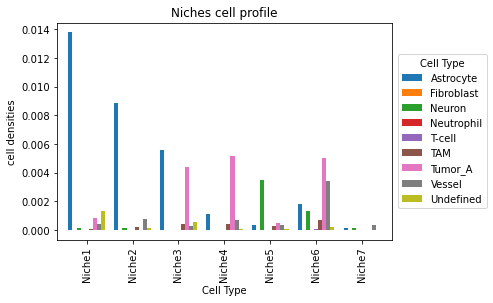

In [10]:
NiCeProDf.plot.bar( title = "Niches cell profile",width=0.8, subplots=False,
           xlabel="Cell Type",ylabel= "cell densities")
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0,
           title='Cell Type').get_figure().savefig("../output/fig/NichCellProfile_celltype_%s.png" %(Imageinfo),
            dpi=300, bbox_inches='tight')

### bar plot of niche cell composition, colored by niches 

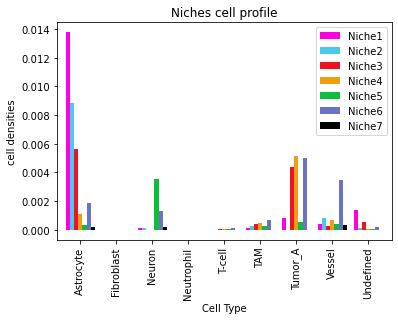

In [11]:
# divide RGB color (COLARCHS) to 255, because plot.bar() in panda package accepts the range between 0 to 1 to specify a color.
Ar_col = []
for i in COLARCHS :
    item = []
    for b in i:
        item.append(b/255)
    Ar_col.append(item)
       
    
pl = NiCeProDf.transpose()

pl.plot.bar(color = Ar_col, title = "Niches cell profile",width=0.8, subplots=False,xlabel="Cell Type",
            ylabel= "cell densities").get_figure().savefig(Fig_path+ "/NichCellProfile_%s.png" %(Imageinfo), 
            dpi=300,bbox_inches='tight')


### Segmenting images into niches and save as svg file


 The computational time for Segmenting images into niches is long... 


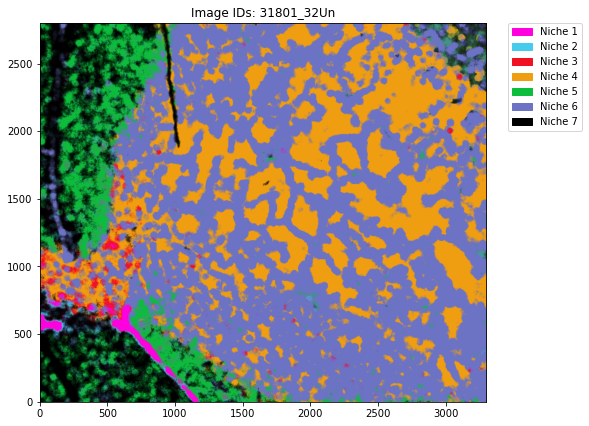

In [14]:

print(" The computational time for Segmenting images into niches is long... ")
for i in ImageIDs:
    GRANULARITY = 5
    CePo = pd.read_csv(Data_Path+"/patient{}_cell_positions.csv".format(i))
    plot_cells_positions(CePo ,ImageIDs, CELLTYPES, segment_image=True, counting_type=METHOD,
                         color_vector=COLARCHS,segmentation_type='colors',
                         granularity=GRANULARITY, radius=RADIUS,pca_obj=PcOb,
                         AA_obj=ArAn, to_plot = 'None',h=YSIZE, w=XSIZE,
                        path_fig= Fig_path+ "/nichesSeg_patient{}.svg".format(i))



### Niche environments of cells
#### In this process, sites’ centers were no longer defined randomly but rather the sites were created in a way that each site has a cell as its central focus by setting the "center_sites_cells" to True

In [15]:

print("Computing cells' niches weights, the operation might take some time for more that one image...")

CeAbCnCeli = generate_abundance_matrix(CELLTYPES, ImageIDs, NSITES,RADIUS,
                                       method=METHOD, snr=3,center_sites_cells=True,
                                       border=False,root=Data_Path)
sitesCC, patients_ids2,sites_ids2, _ = join_abundance_matrices(CeAbCnCeli)

# by using quadratic programming niches weights was calculated
CeNiWgt = compute_cells_niches_weights(niches=NiCePro,cellsSites=sitesCC,nbNiches=NoNi)

SiAr = pd.DataFrame(CeNiWgt)
SiAr['SampleID'] = patients_ids2
SiAr["cell_id"] = sites_ids2[:,0]
SiAr["cell_type"] = sites_ids2[:,1]
SiAr["TOT_cell_dens"]= sitesCC.sum(axis=1)
SiAr.to_csv(Output_path + "/sites_cells_archs_%s.csv" %(Imageinfo),index=False)

#create a dictionary of sites centered on cells and niches weights
CeAbSiCnCeDi = {"cells_niches": SiAr.to_dict()}

# Serializing json objects
CeNiWgt_json = json.dumps(CeAbSiCnCeDi,indent=4) # sites centered on cells and niches weights

print("save cells' niches weights as a json file... ")

# Writing to .json files to be later use in r 
with open(Output_path + "/cells_niches_%s.json" %(Imageinfo),"w") as f5:
    f5.write(CeNiWgt_json)

    
df = pd.read_csv (Output_path + "/sites_cells_archs_%s.csv" %(Imageinfo))
df

Computing cells' niches weights, the operation might take some time for more that one image...
save cells' niches weights as a json file... 


,0,1,2,3,4,5,6,SampleID,cell_id,cell_type,TOT_cell_dens
0,0.000000e+00,2.942013e-02,-3.079824e-18,-4.211865e-15,5.935950e-01,1.757750e-17,3.769849e-01,31801_32Un,128598,Neuron,0.002969
1,0.000000e+00,2.305831e-02,-3.368079e-18,-4.378112e-15,6.004407e-01,1.745743e-17,3.765010e-01,31801_32Un,128600,Neuron,0.002954
2,0.000000e+00,2.900433e-02,-1.707409e-17,-3.992566e-15,5.780741e-01,1.690450e-17,3.929216e-01,31801_32Un,128601,Neuron,0.002923
3,0.000000e+00,4.215264e-02,1.146623e-17,-4.086501e-15,5.357555e-01,1.623135e-17,4.220919e-01,31801_32Un,128602,Neuron,0.002863
4,0.000000e+00,3.190196e-02,-2.934745e-18,-3.581246e-15,5.142126e-01,1.488103e-17,4.538854e-01,31801_32Un,128606,Astrocyte,0.002733
...,...,...,...,...,...,...,...,...,...,...,...
2040,1.387779e-17,3.009954e-17,4.280470e-02,2.223653e-01,-5.835748e-17,7.348300e-01,0.000000e+00,31801_32Un,145359,Tumor_A,0.012233
2041,4.041108e-18,1.106841e-01,7.296811e-20,6.051388e-01,0.000000e+00,1.083895e-01,1.757877e-01,31801_32Un,145360,Vessel,0.006962
2042,0.000000e+00,-1.915802e-18,-4.930451e-32,8.560257e-01,0.000000e+00,-7.781856e-18,1.439743e-01,31801_32Un,145361,Tumor_A,0.005789
2043,-6.671225e-18,-4.282496e-18,1.387779e-17,1.222447e-02,1.874452e-01,8.003303e-01,1.677564e-18,31801_32Un,145362,Vessel,0.011327


In [13]:
# to determine which cell type was eliminated from the sample site due to a small proportion
s_arch = pd.DataFrame(CeNiWgt)
s_arch["cell_type"] = sites_ids2[:,1]

print(s_arch["cell_type"].unique())

['Neuron' 'Astrocyte' 'Vessel' 'TAM' 'Tumor_A' 'Undefined' 'T-cell']
